# 桁計算

桁の情報をExcelシートから読み込み、曲げ剛性などをプロットする方法について説明します。

In [1]:
import sys
sys.path.append("../")
from obj.Beam import Sheet,BeamInfo,Beam
from astropy.units import Quantity
import pandas as pd

## プリプレグシート

プリプレグはそこまで多くの種類を使うわけではないので、コードに書いてしまうほうが楽だと思います。
そこで、ここではコード中で定義する方針をとります。

数値計算でミスが多いのは単位換算です。特にradianとdegreeの変換のミスが多いです。
そのため、この設計プログラム全体でastropyというパッケージを利用しています。
以下に示すように単位自体をかけてやることで単位付き数値を扱うことができます。

内部ではdecompose()を実行していて、SI単位系に変換しています。

In [2]:
HRX350C125S=Sheet(name="HRX350C125S",E=Quantity(40,"t/mm2"),thickness=Quantity(0.096,"mm"),density=Quantity(155,"g/(m2)"),compound_rate=0.664,use="0&45&90&802")
TR3110_381GMX=Sheet(name="TR3110 381GMX",E=Quantity(2,"t/mm2"),thickness=Quantity(0.223,"mm"),density=Quantity(333,"g/(m2)"),compound_rate=0.1,use="クロス",isotropy=True)
spec={1:HRX350C125S,5:TR3110_381GMX}

## PLY構成の読み込み

PLY構成の読み込みは`data/ply.xlsx`の形式であれば、次のようにして簡単に読み込むことができます。

In [3]:
df=pd.read_excel("../data/ply.xlsx",sheet_name=None)
beamA=BeamInfo.read(df["A"],spec)
beamB=BeamInfo.read(df["B"],spec)
beamC=BeamInfo.read(df["C"],spec)
beamD=BeamInfo.read(df["D"],spec)
beam=Beam([beamA,beamB,beamC,beamD],160)

## 曲げ剛性のプロット

例として曲げ剛性をプロットしてみます。デフォルトではSI単位系に揃えるようにしています。

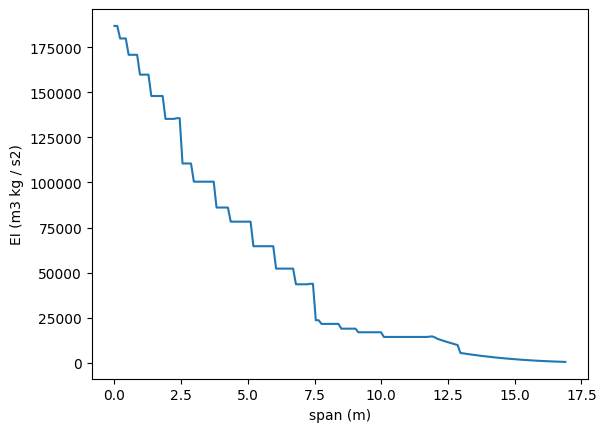

In [4]:
import matplotlib.pyplot as plt
plt.plot(beam.s,beam.EI_eta)
plt.xlabel(f"span ({beam.s.unit})")
plt.ylabel(f"EI ({beam.EI_eta.unit})")
plt.show()

## たわみ計算

微小要素に固定された局所座標系での荷重を与えたときの桁のたわみを計算します。

  0%|          | 0/10 [00:00<?, ?it/s]

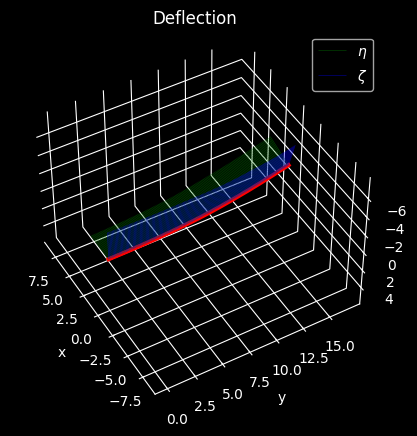

In [5]:
import utils.unit as u
import numpy as np
from matplotlib.axes import Axes

with open("../data/load.npz","rb") as file:
    f=np.load(file) # 荷重読み込み

# たわみ計算
r,U_xi,euler=beam.deflect(f*u.N,0*np.ones((320,3))*u.m,
                    np.array([[0,1,0], # e_xi
                              [-1,0,0], # e_eta
                              [0,0,-1] # e_zeta
                              ]).T)

# 好みに合わせてスタイルを変更
plt.style.use('dark_background')

# 3D plot
ax:Axes=plt.axes(projection='3d')
# たわみ曲線をplot
ax.plot(r[:,0],r[:,1],r[:,2],color='red',linewidth=3)
# 局所座標系ξηζ系の基底ベクトルの向きをplot
ax.quiver3D(r[:,0],r[:,1],r[:,2],U_xi[:,1,0],U_xi[:,1,1],U_xi[:,1,2],length=3,color='green',alpha=0.5,arrow_length_ratio=0,linewidths=0.5,normalize=True,label=r"$\eta$")
ax.quiver3D(r[:,0],r[:,1],r[:,2],U_xi[:,2,0],U_xi[:,2,1],U_xi[:,2,2],length=3,color='blue' ,alpha=0.5,arrow_length_ratio=0,linewidths=0.5,normalize=True,label=r"$\zeta$")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
ax.set_title('Deflection')
# panesを削除
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# 長さを揃える
ax.axis('equal')
# 軸の向きを飛行力学の向きに合わせる
ax.view_init(elev=-135, azim=30)
plt.show()